In [1]:
import optical_gating_analysis as OG
import matplotlib.pyplot as plt
import numpy as np
import j_py_sad_correlation as jps

from scipy.signal import find_peaks
from scipy import signal

import tifffile as tf

In [2]:
data_src = r"E:\data\my data\Arrhythmic imaging April 2024\2024-04-05 17.38.02 vid pre-caffeine 3\Allied Vision Technologies GS650 0001f61c\*tif"
ref_src = r"E:\data\my data\Arrhythmic imaging April 2024\2024-04-05 17.38.02 vid pre-caffeine 3\ref-frames-2024-04-05-17.37.43\*tif"
ref_period = 158.758804

In [3]:
oog = OG.BasicOpticalGating()#.default()
oog.sequence_manager.set_source(data_src)
#oog.sequence_manager.set_reference_sequence(ref_src)
#oog.sequence_manager.reference_period = ref_period
oog.settings["pi_space"] = True
oog.settings["include_reference_frames"] = True
oog.settings["drift_correction"] = True
oog.settings["padding_frames"] = 2
oog.run()

Setting source to E:\data\my data\Arrhythmic imaging April 2024\2024-04-05 17.38.02 vid pre-caffeine 3\Allied Vision Technologies GS650 0001f61c\*tif
Getting reference sequence
Reference period: 160.0736040609137; Reference indices: [23, 188]
Getting SADs
Getting phases


In [4]:
data = oog.sequence_manager.load_tif(oog.sequence_manager.sequence_src)

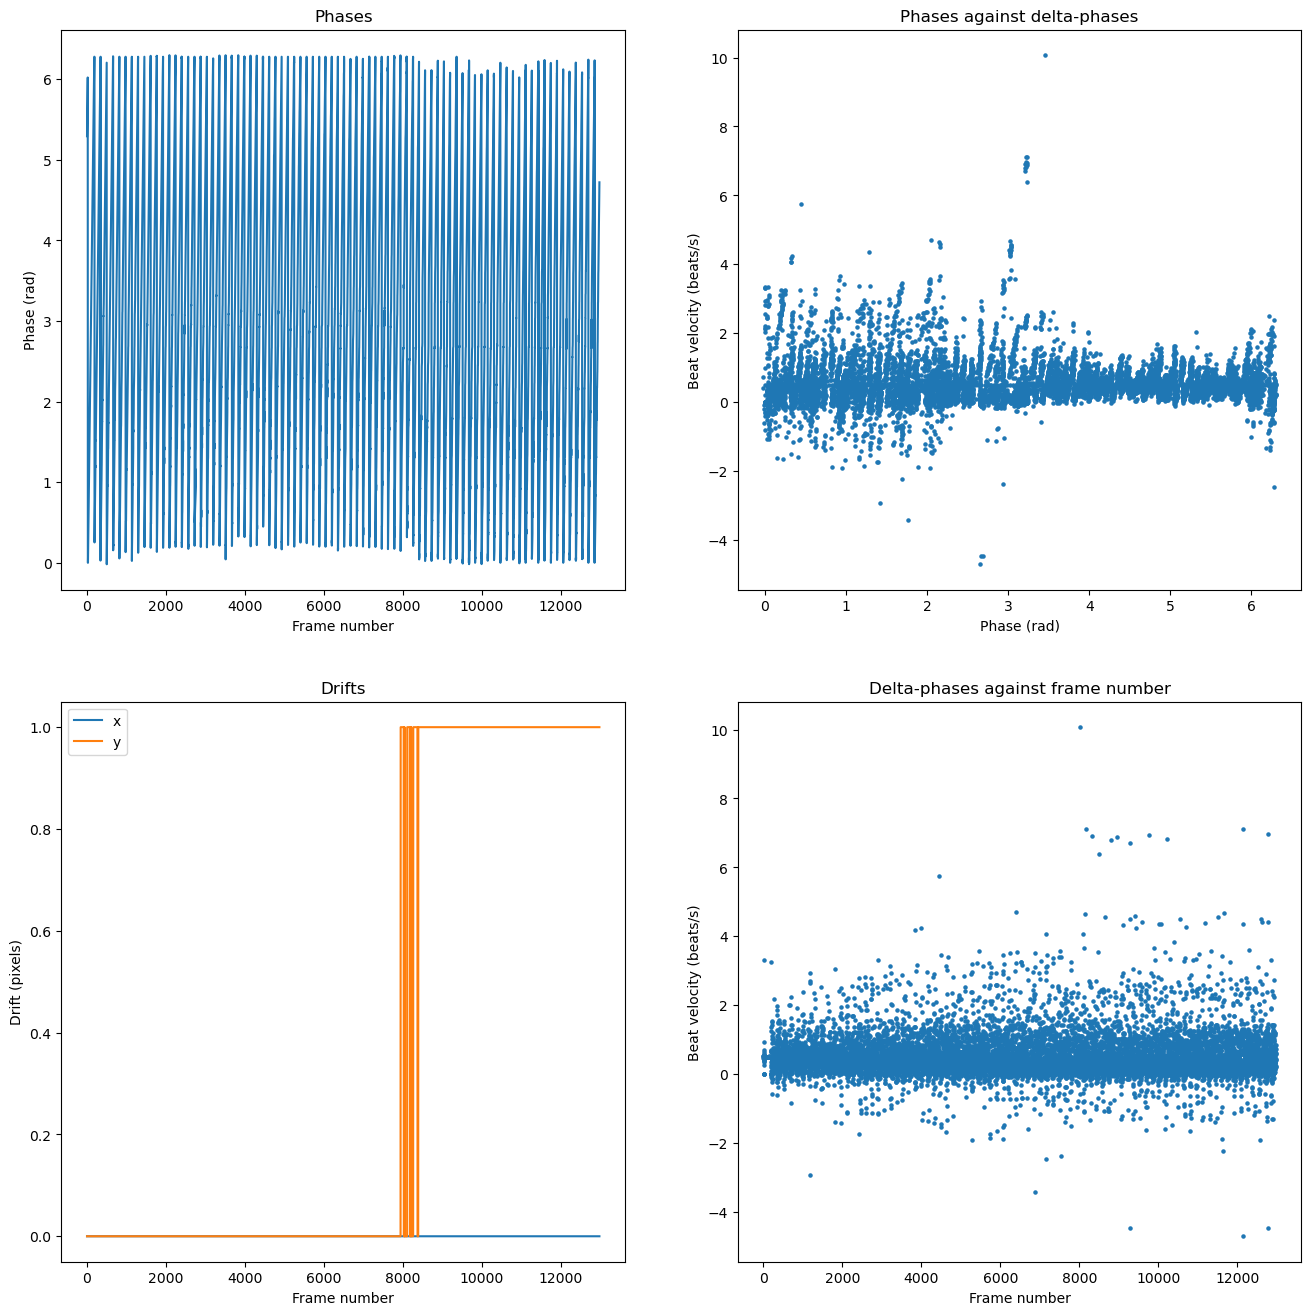

In [5]:
oog.plot_summary()

[0 0]
[0 1]
(12974, 129, 147)


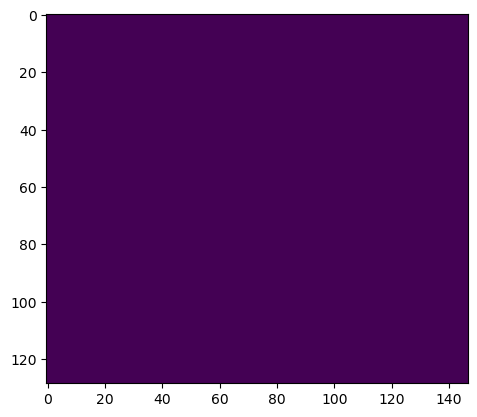

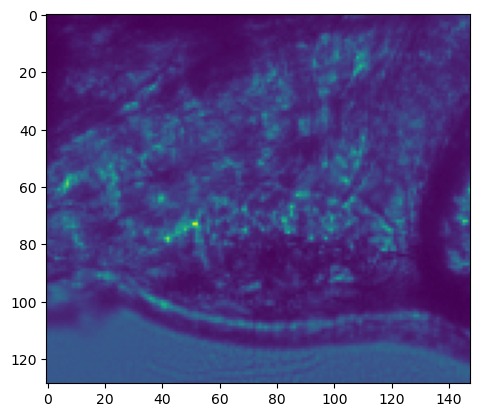

In [40]:
try:
    # Apply oog.drifts correction to data
    # First get max drifts in x and y
    max_drifts = np.abs(np.max(oog.drifts, axis=0))
    min_drifts = np.abs(np.min(oog.drifts, axis=0))
    print(min_drifts)
    print(max_drifts)

    # Create a new array with the shape of original data minus max drifts
    new_data = np.zeros((data.shape[0], data.shape[1]-max_drifts[0]-min_drifts[0], data.shape[2]-max_drifts[1]-min_drifts[1]), dtype=data.dtype)
    print(new_data.shape)

    x0_coords = []
    x1_coords = []
    y0_coords = []
    y1_coords = []
    # Fill new_data with data applying the drift correction offset
    for i in range(data.shape[0]):
        x0 = min_drifts[0] + oog.drifts[i][0]
        x1 = data.shape[1] - max_drifts[0] + oog.drifts[i][0]
        y0 = min_drifts[1] + oog.drifts[i][1]
        y1 = data.shape[2] - max_drifts[1] + oog.drifts[i][1]
        data_to_overwrite = data[i, x0:x1, y0:y1]
    new_data[i] = data_to_overwrite
except:
    # Print the exception
    

    new_data = data

plt.imshow(new_data[0])
plt.show()
plt.imshow(data[0])
plt.show()

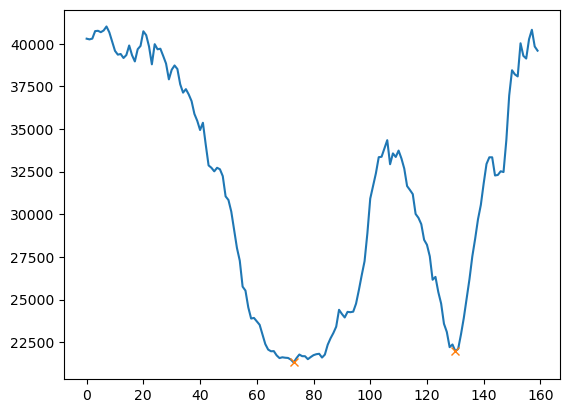

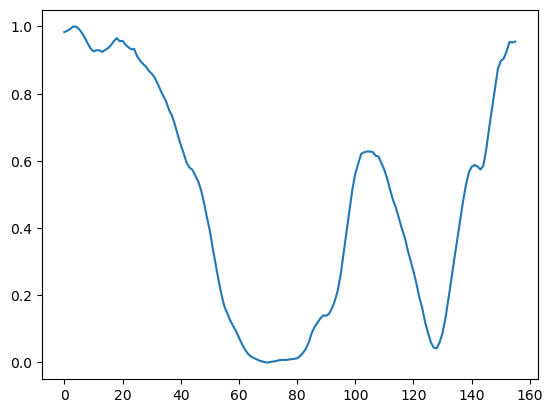

[ 73 130]


In [7]:
ref_seq_diffs = np.sum(np.abs(np.diff(oog.sequence_manager.reference_sequence[2:-2].astype(np.int16), axis=0)), axis=(1,2))
plt.plot(ref_seq_diffs)

# Find minimas of ref_seq_diffs
peaks, _ = find_peaks(-ref_seq_diffs, distance=10, prominence = 2000)
plt.plot(peaks, ref_seq_diffs[peaks], "x")
plt.show()

# Plot moving average
window = 5
moving_avg = np.convolve(ref_seq_diffs, np.ones(window)/window, mode='valid')
moving_avg -= np.min(moving_avg)
moving_avg /= np.max(moving_avg)
plt.plot(moving_avg)
plt.show()

print(peaks)

In [8]:
tf.imwrite(r"D:\Data\phototoxicity\corrected.tif", new_data.astype(np.uint16))

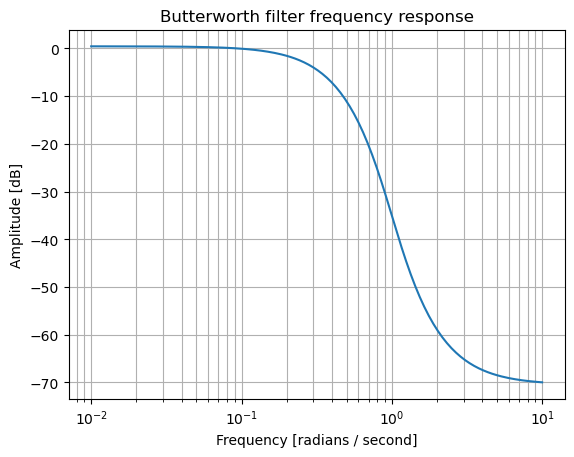

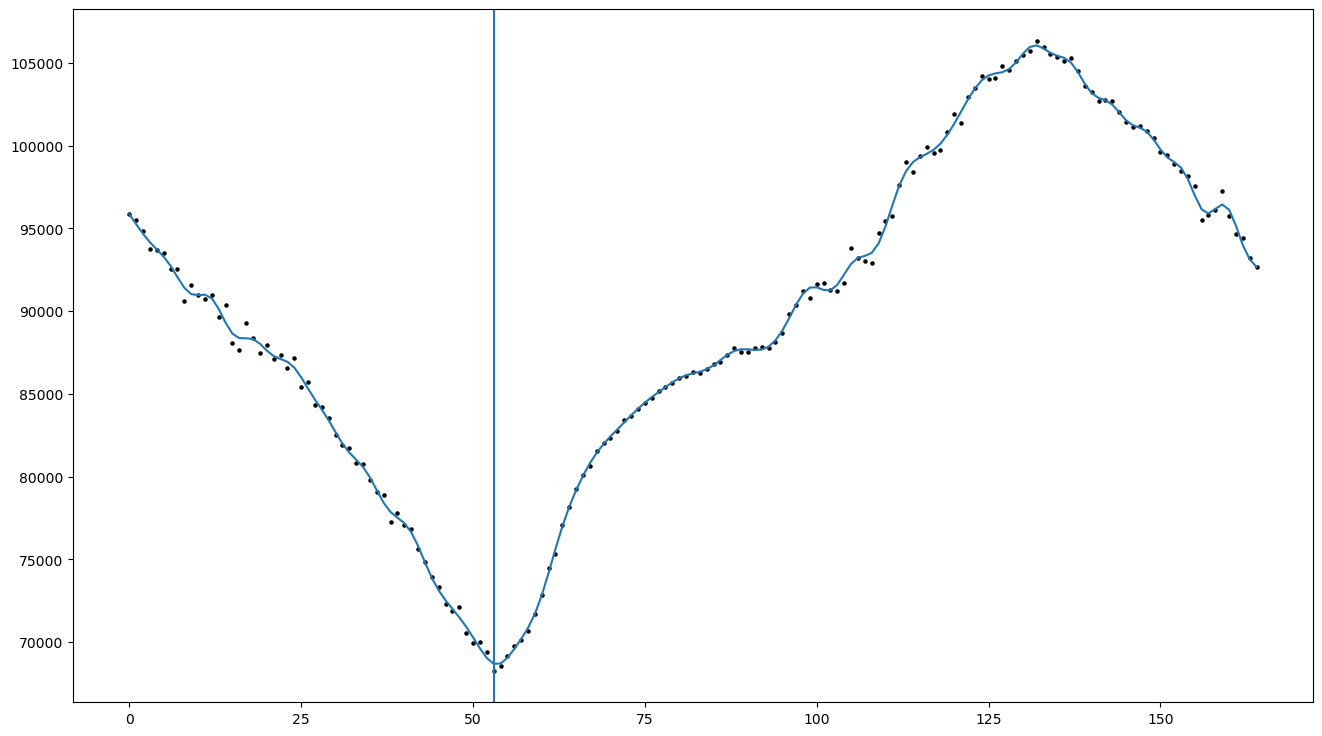

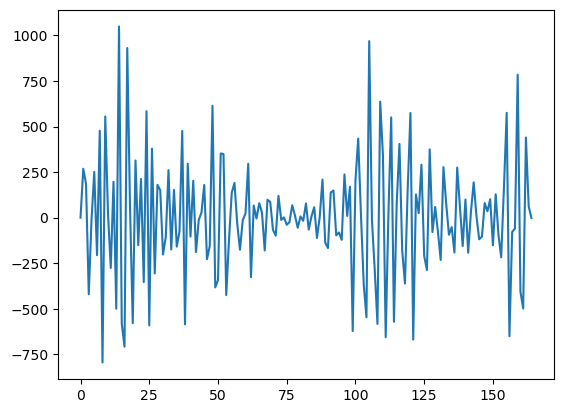

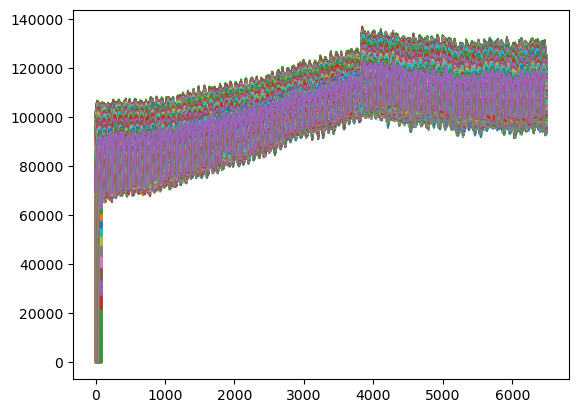

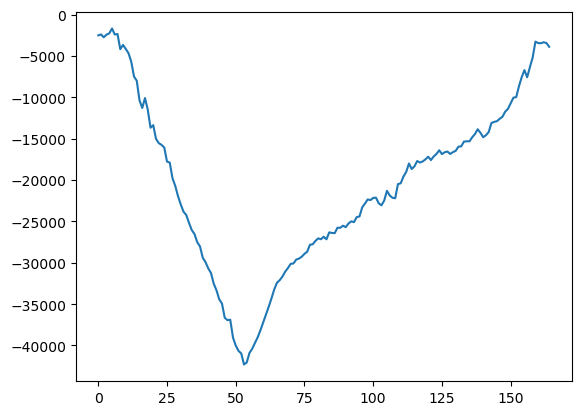

In [9]:
i = 550

sos = signal.butter(10, 60, fs = 320, output = "sos", btype = "lowpass")
y = signal.sosfiltfilt(sos, oog.sads[i])
b, a = signal.butter(10, 60, fs = 320, btype = "lowpass")

w, h = signal.freqs(b, a)

plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.grid(which='both', axis='both')
plt.show()

plt.figure(figsize = (16,9))
plt.axvline(np.argmin(oog.sads[i][oog.settings["padding_frames"]:-oog.settings["padding_frames"]]) + oog.settings["padding_frames"])
plt.plot(y)
plt.scatter(range(len(oog.sads[i])), oog.sads[i], c = "black", s = 5)
plt.show()

plt.plot(oog.sads[i] - y)
plt.show()


plt.plot(np.array(oog.sads)[np.where(oog.phases < np.pi)])
plt.show()
plt.plot(oog.sads[i] - np.mean(np.array(oog.sads)[np.where(oog.phases < np.pi / 8)], axis = 0))

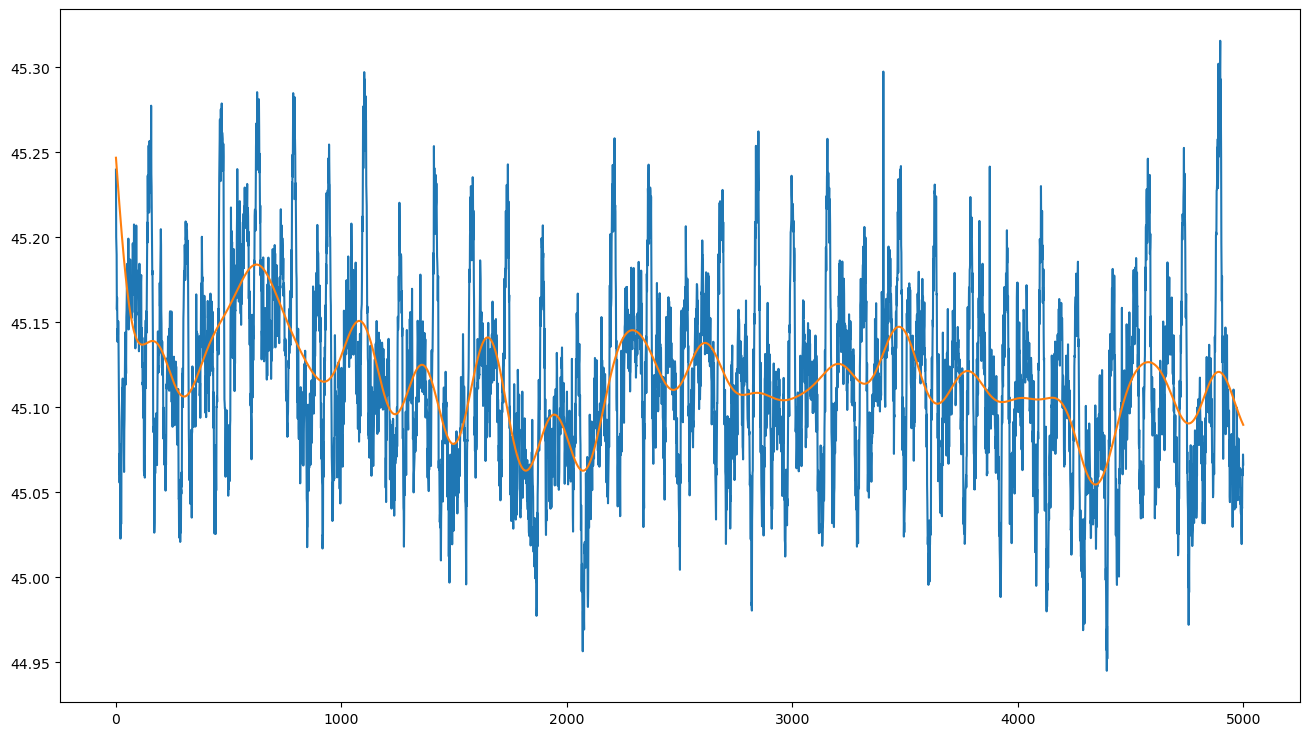

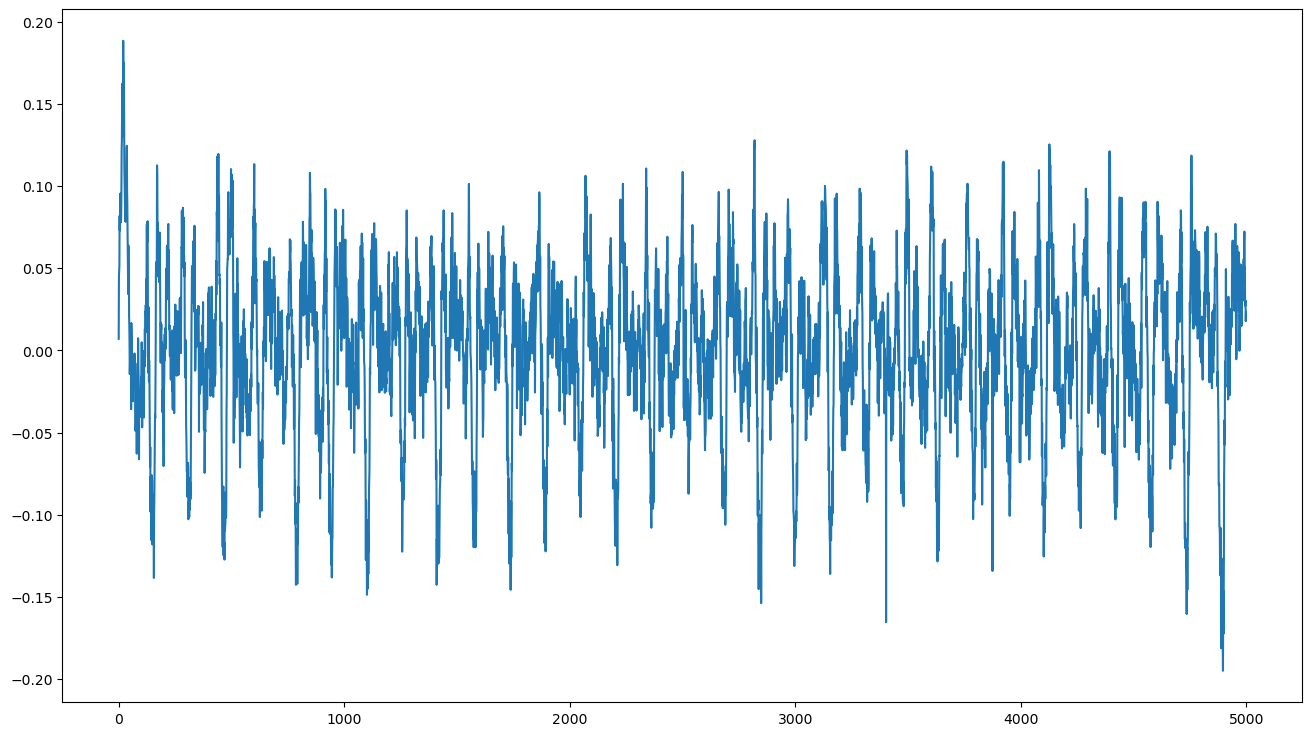

In [10]:
sos = signal.butter(10, 0.7/80, output='sos', btype = "lowpass")

y = signal.sosfiltfilt(sos, oog.frame_means)

plt.figure(figsize = (16,9))
plt.plot(oog.frame_means[0:5000])
plt.plot(y[0:5000])
plt.show()

plt.figure(figsize = (16,9))
plt.plot((y - np.array(oog.frame_means))[0:5000])

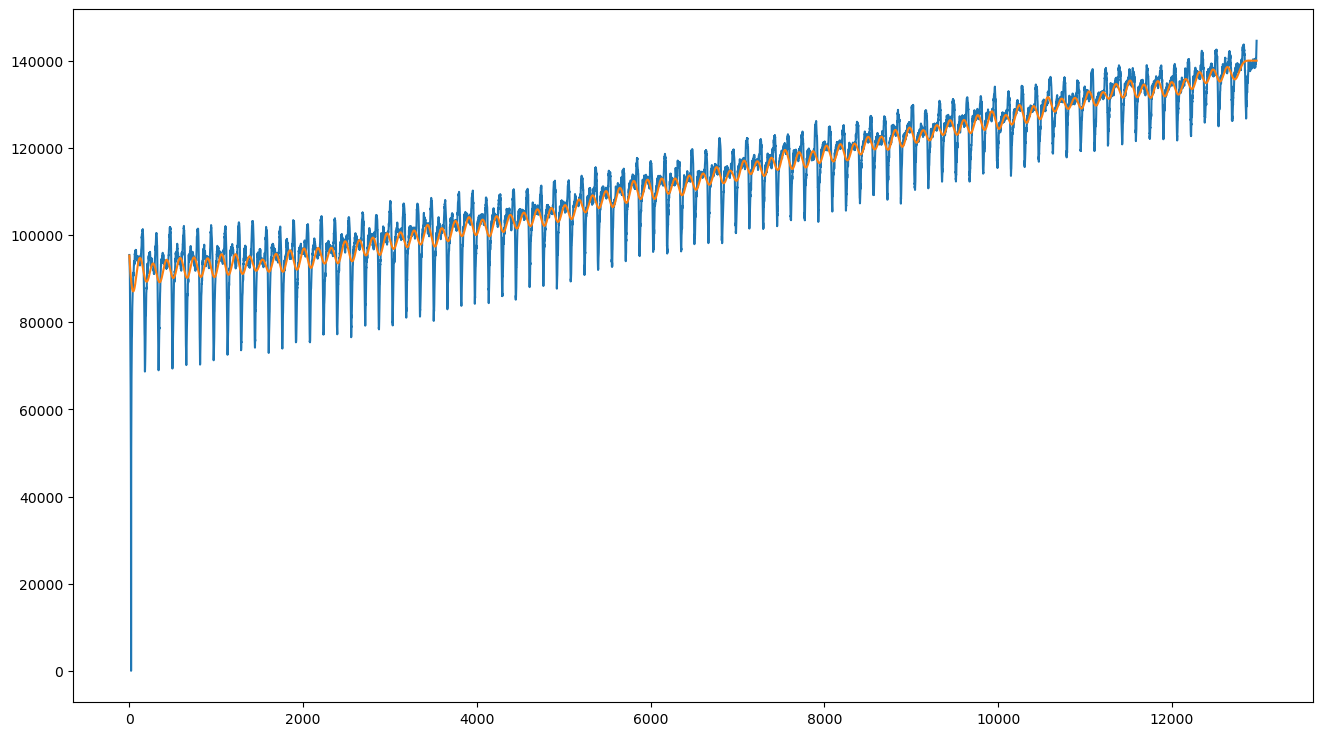

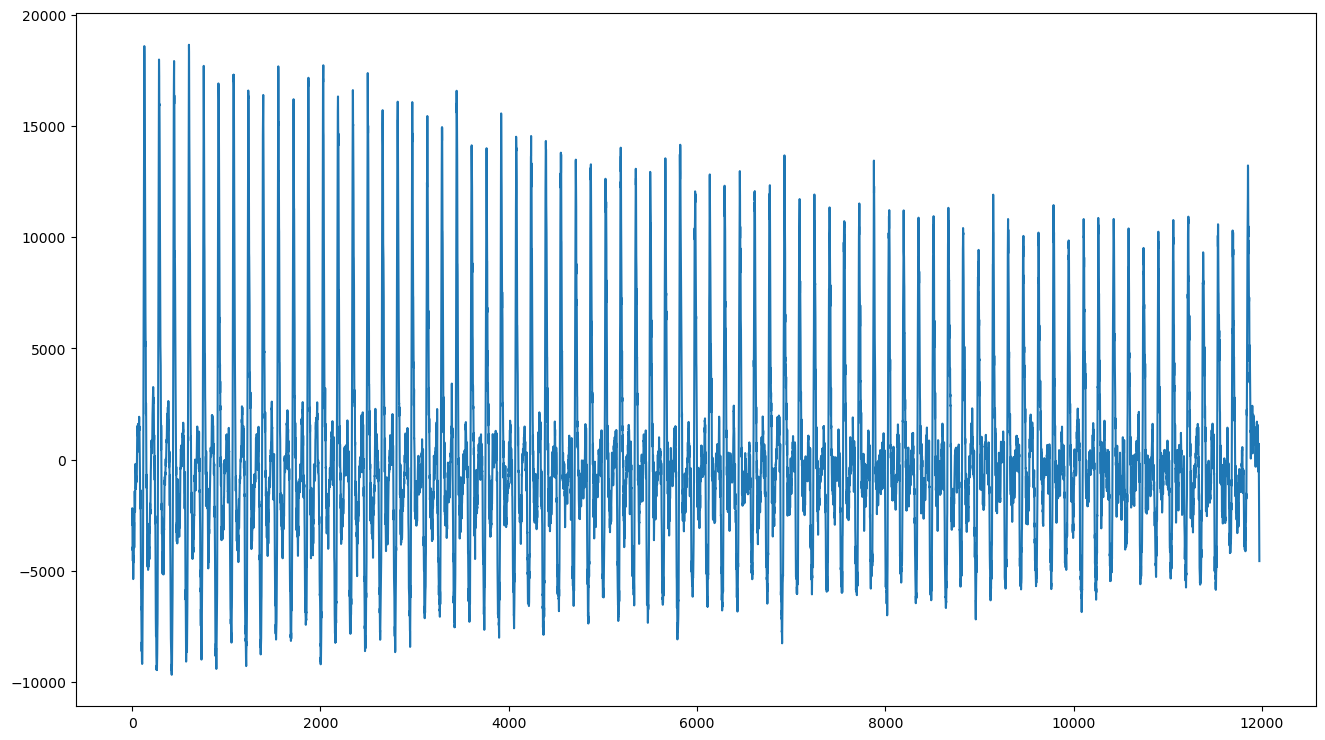

In [11]:
sad = jps.sad_with_references(data[20], data)
#plt.plot(sad)


sos = signal.butter(10, 1/80, output='sos', btype = "lowpass")

y = signal.sosfiltfilt(sos, sad)

plt.figure(figsize = (16,9))
plt.plot(sad)
plt.plot(y)
plt.show()

plt.figure(figsize = (16,9))
plt.plot(-((sad - y)[1000::]))
#plt.plot((-sad[1000::] + 90000)**2)
plt.show()

uint8


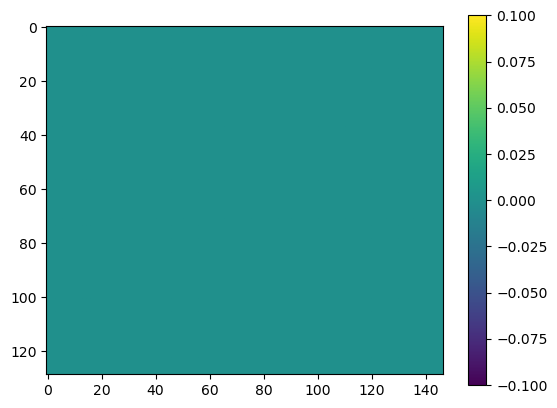

In [38]:
print(new_data.dtype)
plt.imshow(new_data[1])
plt.colorbar()

In [33]:
def detrend(sad):
    x = np.arange(sad.shape[0])
    p = np.polyfit(x, sad, 1)
    fit = np.polyval(p, x)
    return sad - fit

def get_sad(frame, sequence):
    sad = -jps.sad_with_references(frame, sequence)
    sad = detrend(sad)
    sad -= np.min(sad)
    sad /= np.max(sad)

    return sad

def get_sad_peaks(sad, height, distance, prominence):
    peaks, _ = find_peaks(sad, height=height, distance = distance, prominence = prominence)
    return peaks

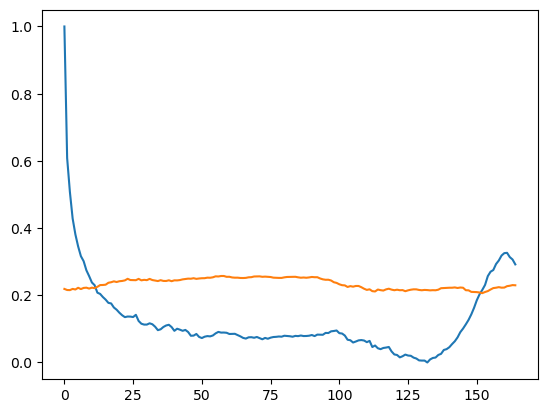

In [26]:
sads = []
for i in range(oog.sequence_manager.reference_sequence.shape[0]):
    sads.append(get_sad(oog.sequence_manager.reference_sequence[i], data))

plt.plot(get_sad(oog.sequence_manager.reference_sequence[0], oog.sequence_manager.reference_sequence))
plt.plot(np.mean(sads, axis = 1))
plt.show()

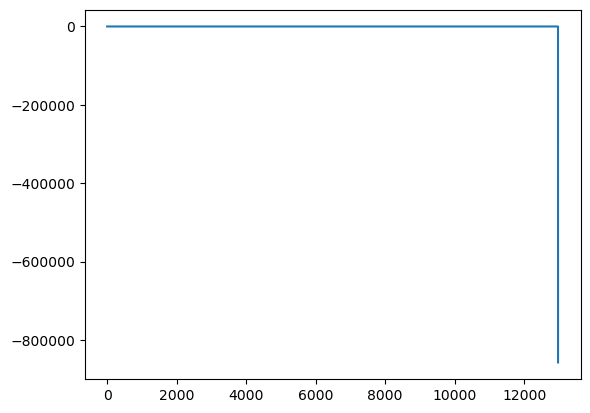

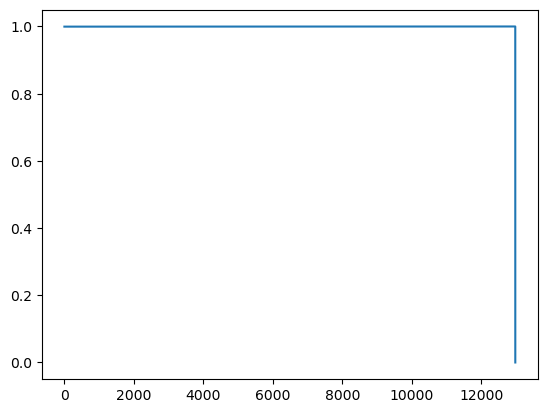

In [32]:
# Initialise settings
detrend_order = 10
height = 0.1
distance = oog.sequence_manager.reference_sequence.shape[0] // 2
prominence = 0.1

# Get peaks
sad = get_sad(new_data[0], new_data)
peaks = get_sad_peaks(sad, height, distance, prominence)

plt.plot(sad)

# Get HR using delta phases
delta_phase_HRs = []
for i in range(0, int(len(peaks) // 1.5)):
    delta_phase_HRs.append(np.mean(oog.delta_phases[peaks[i]:peaks[i + 1]]))

# Initialise arrays
HRs = []
HRs_close = []
peak_locs_all = []
no_of_peaks = [len(peaks)]
for i in range(len(peaks)):
    # Get peaks
    sad = get_sad(new_data[peaks[i]], new_data)
    peaks_2 = get_sad_peaks(sad, height, distance, prominence)
    sad = -sad
    peak_locs = []

    # Get subpeaks
    for j in range(len(peaks_2)):
        subframe = OG.v_fitting(sad[peaks_2[j] - 1], sad[peaks_2[j]], sad[peaks_2[j] + 1])[0]
        peak_locs.append(peaks_2[j] + subframe)

    # Save to Array
    if i < int(len(peaks) // 1.5):
        HRs_close.append((2 * np.pi) / (peak_locs[i+1] - peak_locs[i]))
    HR = (2 * np.pi) / np.diff(peak_locs[0:int(len(peaks) // 1.5)])
    HRs.append(HR)

    no_of_peaks.append(len(peaks_2))

HRs = np.array(HRs).transpose()



In [22]:
print(HRs)

[]


AxisError: axis 1 is out of bounds for array of dimension 1

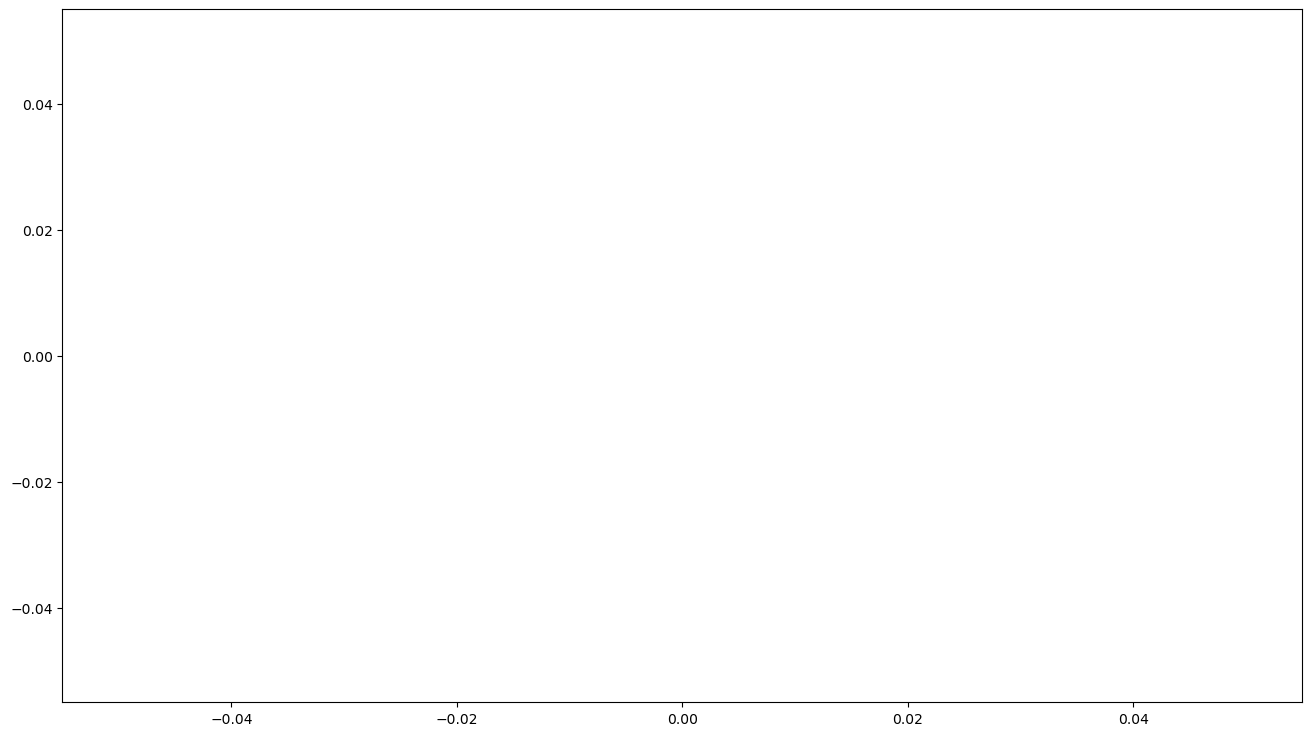

In [16]:
plt.figure(figsize = (16,9))
plt.plot(HRs, "x", ls = ":", lw = 0, ms = 1, c = "blue", alpha = 0.3)
plt.fill_between(range(len(HRs)), np.mean(HRs, axis=1) + np.std(HRs, axis = 1), np.mean(HRs, axis=1) - np.std(HRs, axis = 1), alpha = 0.5)
plt.plot(np.mean(HRs, axis=1), c = "black", lw = 2, zorder = 10, label = "Mean HR")
plt.plot(HRs_close, lw = 2, zorder = 11, c = "orange", label = "Forward differences")
plt.plot(delta_phase_HRs, c = "green", label = "Delta-phases HRs")
plt.legend()
plt.show()

plt.plot(np.cumsum(np.mean(HRs, axis = 1)) - np.cumsum(delta_phase_HRs[1::]))
plt.show()

In [17]:
# Gets the noise spectrum by looking at the standard deviation of the change in delta phases over some time period.
def get_noise_spectrum(delta_phases, averaging_window):
    time_windows = range(1, (delta_phases.shape[0] - averaging_window) // 2)
    avg_delta_phases_std = []
    for time_window in time_windows:
        avg_delta_phases = []
        for i in np.arange(delta_phases.shape[0] - time_window - averaging_window):
            average_delta_phase_init = np.mean(delta_phases[i:i + averaging_window])
            average_delta_phase_final = np.mean(delta_phases[i + time_window:i + time_window + averaging_window])

            est_avg_delta_phases = average_delta_phase_init - average_delta_phase_final

            avg_delta_phases.append(est_avg_delta_phases)

        avg_delta_phases_std.append(np.std(avg_delta_phases))

    return time_windows, avg_delta_phases_std

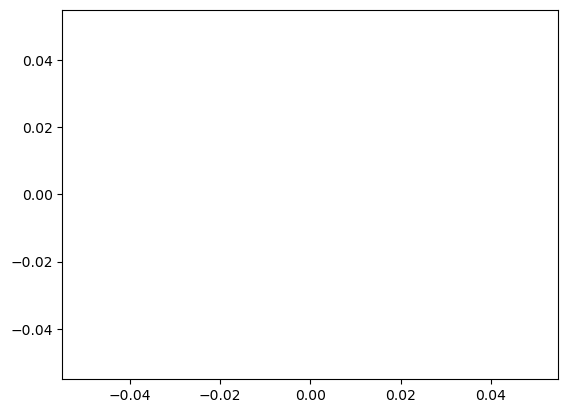

In [18]:
plt.plot(*get_noise_spectrum(np.array(HRs_close), 3))

In [ ]:
print(HRs)

[[0.03948669 0.03946376 0.03947284 ... 0.03933916 0.03933417 0.03955736]
 [0.03979177 0.03981011 0.03981827 ... 0.03986853 0.0400611  0.03983384]
 [0.03955825 0.0396001  0.0395534  ... 0.03932554 0.03954718 0.03938894]
 ...
 [0.03972175 0.03939455 0.03952097 ... 0.03950099 0.03954892 0.03962851]
 [0.03952618 0.03963219 0.03940973 ... 0.0394985  0.03927767 0.03938732]
 [0.03922868 0.03967824 0.0394074  ... 0.03940769 0.03954063 0.03964026]]


In [ ]:
time_windows = np.arange(2, 10)

stds = []
for time_window in time_windows:
    std = []
    for distances in range(1, 20):
        stds.append(np.std(HRs[0:distances], axis=0))